In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import os

In [2]:
df = pd.read_parquet("../data/weighted_r2/N_tau_relationship")

### Extract by median r2 per N and noise level

In [3]:
records = list()
for N in df["N"].unique():
    for noise in df.loc[df["N"]==N, "noise"].unique():
        temp_df = df.loc[(df["N"]==N) & (df["noise"]==noise)]
        
#         r2 = temp_df["r2"].quantile(q=0.5, interpolation="higher") # get r2 median value
        r2 = temp_df["r2"].max()
        temp_df = temp_df.loc[temp_df["r2"]==r2]
        tau, beta_ind = int(temp_df["tau"].mean()), int(temp_df["beta_ind"].mean()) # get corresponding beta_ind and tau
        
        records.append({
            "N":N,
            "noise":noise,
            "beta_ind":beta_ind,
            "r2": r2,
            "tau":tau
        })
        

In [4]:
df_result = pd.DataFrame.from_records(records)

<AxesSubplot:xlabel='N', ylabel='tau'>

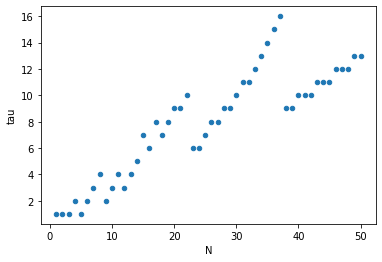

In [5]:
df_result.loc[df_result["noise"]==0.0].plot(kind='scatter', x='N', y="tau")

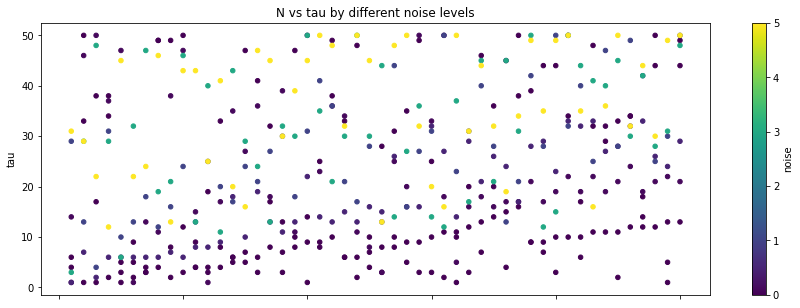

In [8]:
# plotly
fig = px.line(data_frame=df_result, x="N", y="tau", color="noise", hover_data=["beta_ind", "r2"],
#            size="beta_ind",
#            trendline="ols",
                title="N vs tau by different noise levels")
fig.show()

# matplotlib
df_result.plot(kind="scatter", x="N", y="tau", c="noise", cmap="viridis", 
               figsize=(15,5), title="N vs tau by different noise levels");

In [7]:
# save plotly
os.makedirs("../data/weighted_r2/plots", exist_ok=True)
fig.write_html("../data/weighted_r2/plots/N_tau_relationship.html")

### How to Report Results

In [11]:
from statsmodels.api import OLS, add_constant

In [9]:
df_best_no_noise = df.loc[df.loc[(df['noise']==0) & (df['beta_ind'] != 0)].groupby("N")['r2'].idxmax(), ["N","tau"]].reset_index(drop=True)

In [12]:
X = df_best_no_noise["N"]
y = df_best_no_noise['tau']
reg = OLS(y, add_constant(X)).fit()

In [20]:
# reg = LinearRegression().fit(df_best_no_noise['N'].values.reshape(-1, 1), df_best_no_noise['tau'].values.reshape(-1, 1))

In [13]:
df_best_no_noise['least_squares_tau'] = reg.predict()

Simulation Results (noise=0 and beta_ind != 0):
tau = 0.24873949579831944 * N + 1.6171428571428534


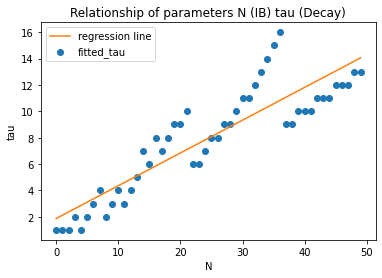

In [39]:
import matplotlib.pyplot as plt
print("Simulation Results (noise=0 and beta_ind != 0):")
print(f"tau = {reg.params['N']} * N + {reg.params['const']}")
plt.scatter(df_best_no_noise.index, df_best_no_noise['tau'], label="fitted_tau")
plt.plot(df_best_no_noise['least_squares_tau'], c='tab:orange', label="regression line")
plt.xlabel("N")
plt.ylabel("tau")
plt.legend()
plt.title("Relationship of parameters N (IB) tau (Decay)");
# df_best_no_noise.set_index('N').plot();

In [37]:
reg.f_pvalue

3.687368534227035e-18

In [26]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tau   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     186.6
Date:                Wed, 24 Aug 2022   Prob (F-statistic):           3.69e-18
Time:                        21:16:59   Log-Likelihood:                -100.90
No. Observations:                  50   AIC:                             205.8
Df Residuals:                      48   BIC:                             209.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6171      0.533      3.031      0.004       0.545       2.690
N              0.2487      0.018     13.662      0.000       0.212       0.285
==============================================================================
Omnibus:                        8.156   Durbin-Watson:                   0.622
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.003
Skew:                           0.978   Prob(JB):                       0.0183
Kurtosis:                       3.138   Cond. No.                         59.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""